# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from torchsummary import summary


## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [2]:
import utils

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [3]:
device = utils.get_device()

cuda available: False ; cudnn available: False ; num devices: 0 ;mps available: True
Using device cpu/mps


In [4]:
data_dir = '/Users/simonblaue/ownCloud/Master/Deep Learning for Computer Vision/data/'
batch_size = 256

# TODO grab data, generate split, init data loaders

cifar10_train, cifar10_test, cifar10_mean, cifar10_std = utils.grab_data(data_dir=data_dir)
trainset, valset = utils.generate_train_val_data_split(cifar10_train)
trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, cifar10_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [5]:
# TODO define loss function
loss_fn = torch.nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

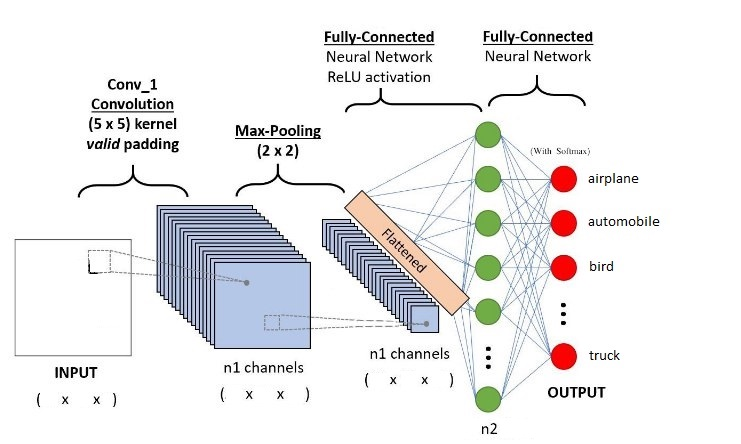

#### **Questions**

Channels:3
Widht: 32
Height: 32
n_filters: 32

- What are the input dimensions? (Channels, Width, Height) -> (3, 32, 32)

- For feature map/pooling: ((width-kernalWidth+2*padding)/stride)+1  
- -> ((32-5+2x0)/1)+1 = 28
- -> ((28-2+2x0)/2)+1 = 14

- What are the dimensions of the feature maps? (n_filters, 28, 28)
- What are the dimensions after pooling? (n_filters, 14,14)
- What is the value for n2 (in_features)? 3*n_filters x 27 x27 = 69.984
- What is the number of parameters for conv_1? (kernelsize^2 * n_filters) = 800

**Your answers here**

In [6]:
# TODO define model

class OneLayerCNN(torch.nn.Module):

  def __init__(self, img_width, num_in_channels, num_classes) -> None:
    super().__init__()

    conv_kernel_size = 5
    conv_padd = 0
    conv_stride = 1
    pool_kernel_size = 2
    pool_padd = 0
    pool_stride = 2
    num_filters = 32

    one_dim_after_conv = int((img_width-conv_kernel_size+2*conv_padd)/conv_stride)+1
    one_dim_after_pool = int((one_dim_after_conv-pool_kernel_size+2*pool_padd)/pool_stride)+1

    linear_in_size = one_dim_after_pool**2*num_filters


    self.layers = torch.nn.Sequential(
      nn.Conv2d(in_channels=num_in_channels, out_channels=num_filters, kernel_size=conv_kernel_size, stride=conv_stride, padding='valid'),
      nn.MaxPool2d(kernel_size=pool_kernel_size),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=linear_in_size, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=num_classes)
    )

  def forward(self, x):
    """ Defines the computation performed at every call. """
    # What are the dimensions of your input layer?
        
    for layer in self.layers:
        x = layer(x)
    return x

In [7]:
model = OneLayerCNN(32,3,10)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                  [-1, 512]       3,211,776
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 12.28
Estimated Total Size (MB): 12.64
----------------------------------------------------------------


#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 104 seconds.


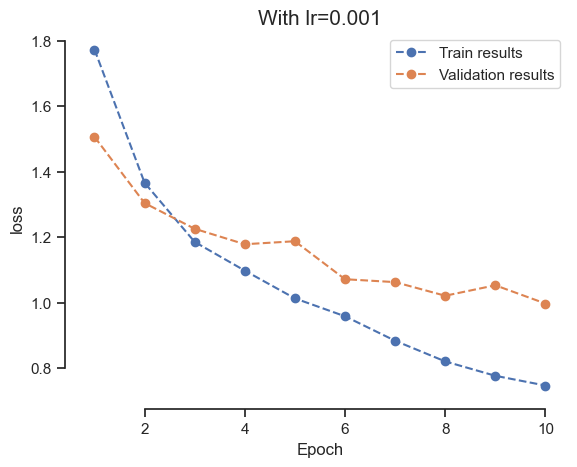

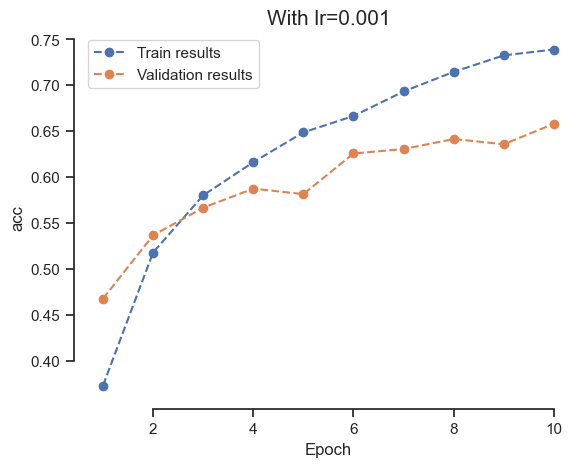

Minimal validation lost: 0.9976359844207764, occured at epoch: 9
Maximal accuracy: 0.6581, occured at epoch: 9


In [8]:
# TODO train and plot
lr = 0.001
patience = 3
save_path = 'saves/model_first'
model = OneLayerCNN(img_width=32, num_in_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# early_stopper=utils.EarlyStopper(model=model, verbose=False, path=save_path, patience_number=patience)
early_stopper = None
res = utils.run_training(model=model, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=10, train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stopper)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = res
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses, val_results=val_losses)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs, val_results=val_accs)
plt.show()
utils.print_best(val_losses, val_accs)


#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

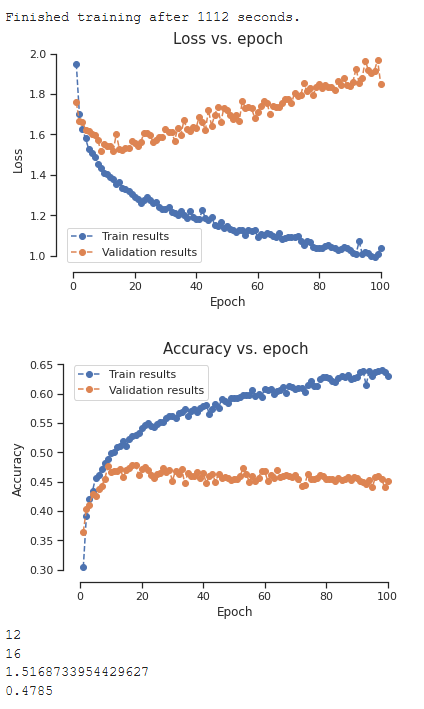

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 513 seconds.


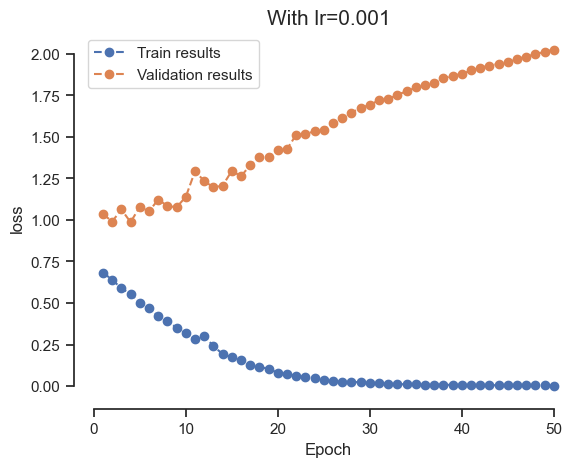

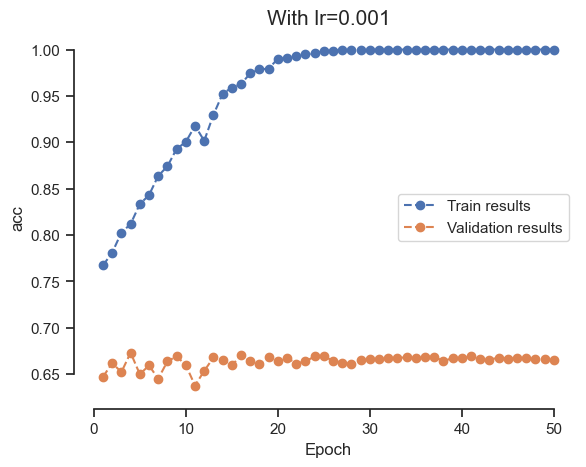

Minimal validation lost: 0.9866959691047669, occured at epoch: 3
Maximal accuracy: 0.6732, occured at epoch: 3


In [9]:
# TODO train and plotlr = 0.001

res = utils.run_training(model=model, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=50, train_dataloader=trainloader, val_dataloader=valloader, early_stopper=early_stopper)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = res
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses, val_results=val_losses)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs, val_results=val_accs)
plt.show()
utils.print_best(val_losses, val_accs)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**
- heavily overfitted
- accuracy stops after 12 epochs for validation
- extract more features with more convs


## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

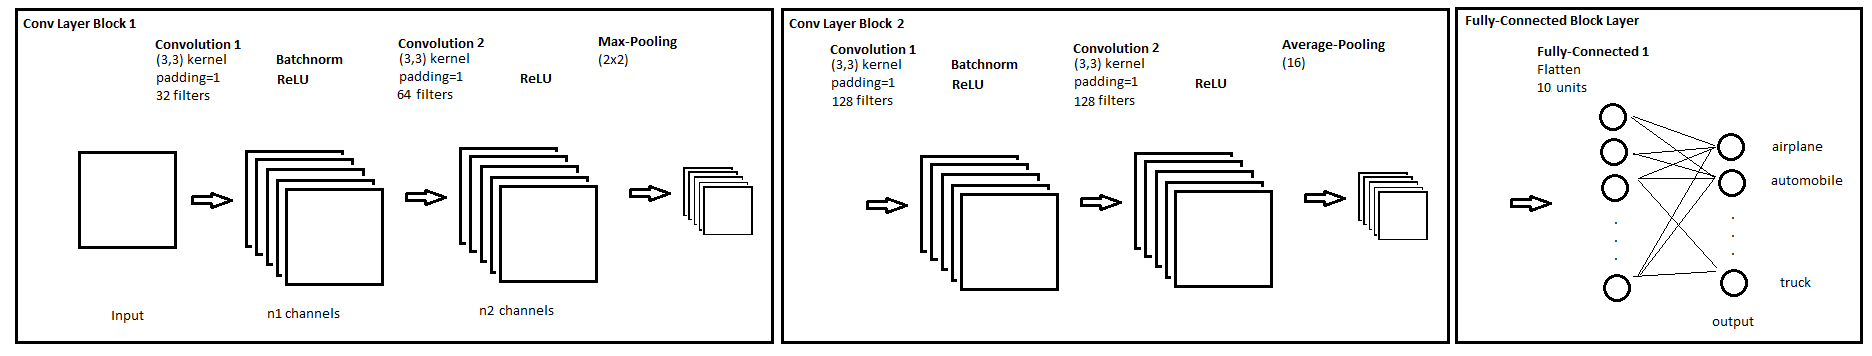

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

In [7]:
class BetterCNN(torch.nn.Module):

  def __init__(self, num_in_channels, num_classes) -> None:
    super().__init__()

    conv_block_1 = torch.nn.Sequential(
      nn.Conv2d(in_channels=num_in_channels, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    conv_block_2 = torch.nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
       nn.ReLU(),
      nn.AvgPool2d(kernel_size=16)
    )

    fully_connected_block = torch.nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=128 , out_features=num_classes)
    )

    self.layers = torch.nn.Sequential(
      conv_block_1,
      conv_block_2,
      fully_connected_block
    )


  def forward(self, x):
    """ Defines the computation performed at every call. """
    # What are the dimensions of your input layer?
    for layer in self.layers:
        x = layer(x)
    return x

In [8]:
model2 = BetterCNN(3,10)
summary(model2, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
           Linear-14                   

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 476 seconds.


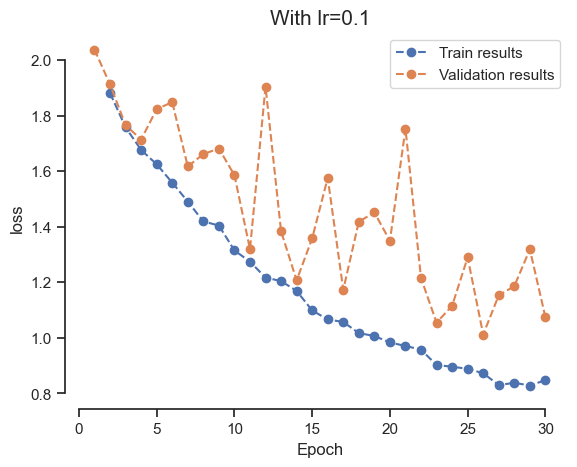

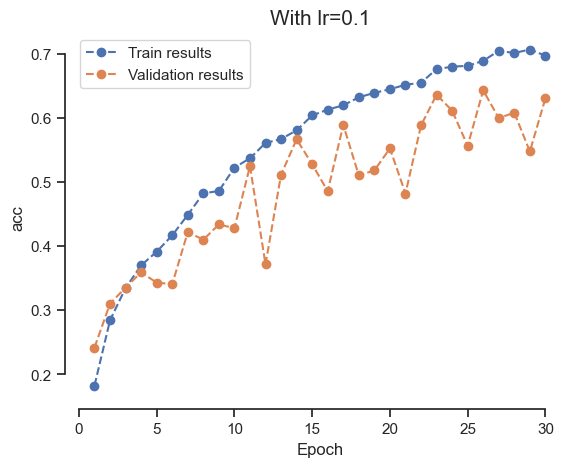

Minimal validation lost: 1.0118467688560486, occured at epoch: 25
Maximal accuracy: 0.643, occured at epoch: 25


In [11]:
# TODO train and plot
lr = 0.1
model2 = BetterCNN(num_in_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr)

res = utils.run_training(model=model2, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=30, train_dataloader=trainloader, val_dataloader=valloader)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = res
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses, val_results=val_losses)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs, val_results=val_accs)
plt.show()
utils.print_best(val_losses, val_accs)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

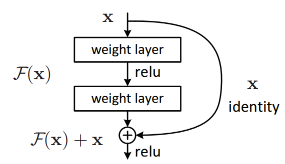

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

1. Easaly trainabale, backprop easaly goeas back the skips and hence weights easily updatable
2. residualas (Rückstände) of early layers will get into later layers
3. When training huge nets

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

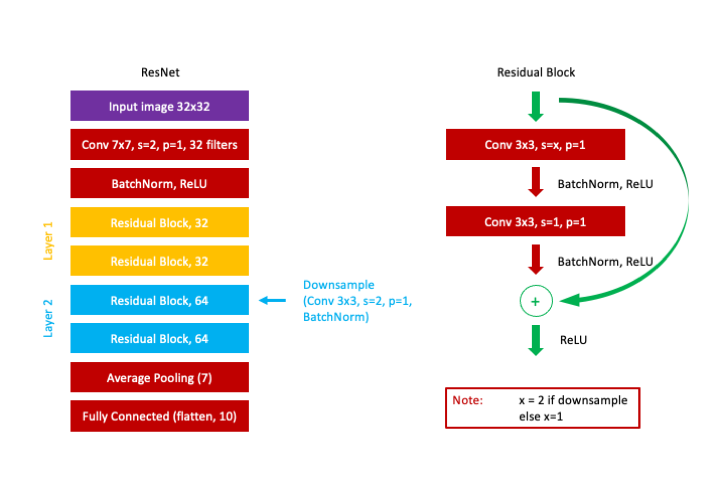

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [7]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
  def __init__(self, filters_in, downsample=False) -> None:
    super().__init__()

    if downsample:
      stride1 = 2 
      filters_out  = filters_in *2
    else: 
      stride1 = 1
      filters_out = filters_in
      
    self.residual = nn.Conv2d(filters_in, filters_out, kernel_size=1, stride=stride1)
    
    
    self.layers = nn.Sequential(
      nn.Conv2d(in_channels=filters_in, out_channels=filters_out, stride=stride1, kernel_size=3, padding=1),
      nn.BatchNorm2d(filters_out),
      nn.ReLU(),
      nn.Conv2d(in_channels=filters_out, out_channels=filters_out, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(filters_out),
    )

  def forward(self,x):
    res = self.residual(x)
    out = self.layers(x)
    return out + res

In [8]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
  def __init__(self, in_channels, out_channels) -> None:
    super().__init__()

    self.layers = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(7,7), padding=1, stride=2),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      ResidualBlock(32, downsample=False),
      nn.ReLU(),
      ResidualBlock(32, downsample=False),
      nn.ReLU(),
      ResidualBlock(32, downsample=True),
      nn.ReLU(),
      ResidualBlock(64, downsample=False),
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=7),
      nn.Flatten(),
      nn.Linear(64, out_channels)
    )

  def forward(self,x):
    return self.layers(x)


In [128]:
# TODO train ResNet, using the architecture laid out in the comments and figures above

model3 = ResNet(in_channels=3, out_channels=10)
summary(model3, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           1,056
            Conv2d-5           [-1, 32, 14, 14]           9,248
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           9,248
       BatchNorm2d-9           [-1, 32, 14, 14]              64
    ResidualBlock-10           [-1, 32, 14, 14]               0
             ReLU-11           [-1, 32, 14, 14]               0
           Conv2d-12           [-1, 32, 14, 14]           1,056
           Conv2d-13           [-1, 32, 14, 14]           9,248
      BatchNorm2d-14           [-1, 32,

In [129]:
# TODO train and plot
lr = 0.1
model3 = ResNet(in_channels=3, out_channels=10).to(device)
optimizer = optim.Adam(model3.parameters(), lr=lr)

res_resnet = utils.run_training(model=model3, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=30, train_dataloader=trainloader, val_dataloader=valloader)
train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = res_resnet


Finished training after 346 seconds.


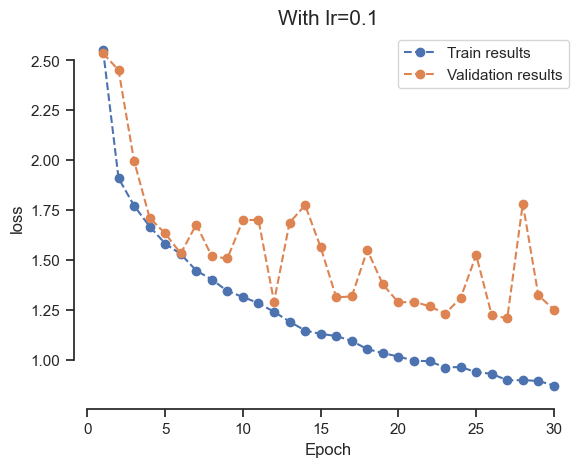

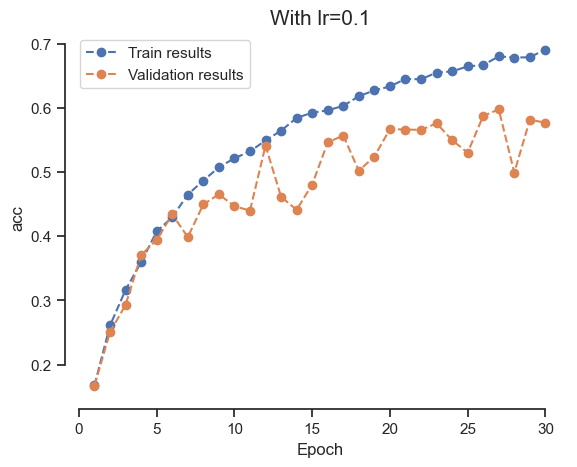

Minimal validation lost: 1.2079351663589477, occured at epoch: 26
Maximal accuracy: 0.5977, occured at epoch: 26


In [130]:
# TODO plot loss and accuracy for training and validation set
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses_resnet, val_results=val_losses_resnet)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs_resnet, val_results=val_accs_resnet)
plt.show()
utils.print_best(val_losses_resnet, val_accs_resnet)

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

1. no, not realy more parameters
2. faster around quarter of time

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

# Did it in utils py, can be found in my GitHub: https://github.com/simonblaue/Deep-Learning-for-Computer-Vision.git


Finished training after 114 seconds.


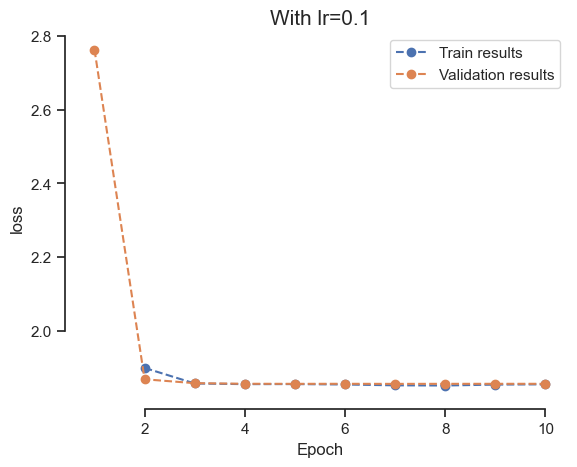

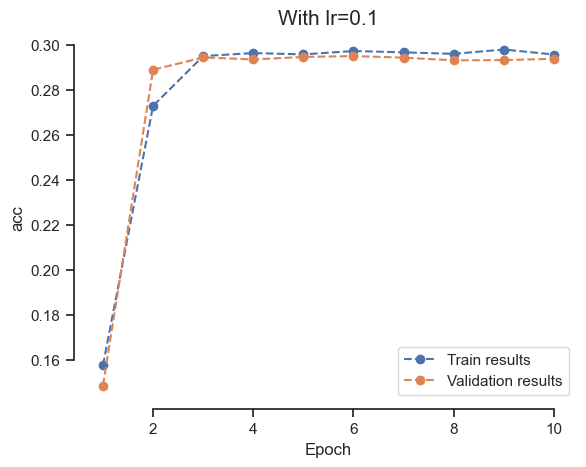

Minimal validation lost: 1.8557796359062195, occured at epoch: 6
Maximal accuracy: 0.2952, occured at epoch: 5


In [10]:
# TODO train and plot with step size 1, gamma 0.1

# TODO train and plot
lr = 0.1
model3 = ResNet(in_channels=3, out_channels=10).to(device)
optimizer = optim.Adam(model3.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

res_resnet = utils.run_training(model=model3, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=10, train_dataloader=trainloader, val_dataloader=valloader, scheduler=scheduler)
train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = res_resnet
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses_resnet, val_results=val_losses_resnet)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs_resnet, val_results=val_accs_resnet)
plt.show()
utils.print_best(val_losses_resnet, val_accs_resnet)

Finished training after 114 seconds.


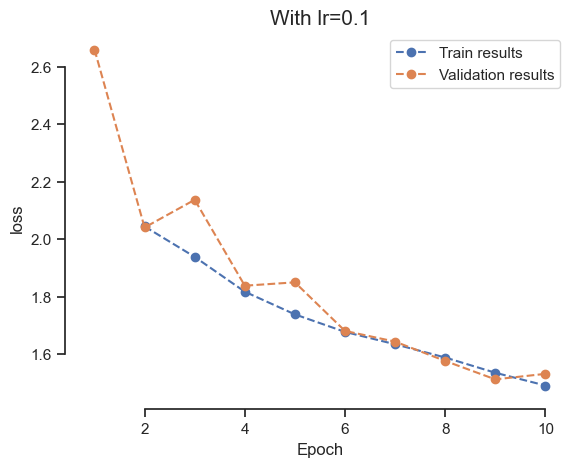

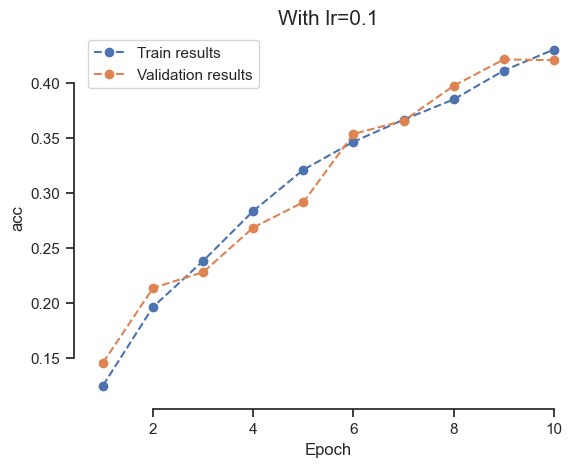

Minimal validation lost: 1.5129703521728515, occured at epoch: 8
Maximal accuracy: 0.4215, occured at epoch: 8


In [11]:
# TODO train and plot with step size 1, gamma 0.9

lr = 0.1
model3 = ResNet(in_channels=3, out_channels=10).to(device)
optimizer = optim.Adam(model3.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

res_resnet = utils.run_training(model=model3, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=10, train_dataloader=trainloader, val_dataloader=valloader, scheduler=scheduler)
train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = res_resnet
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses_resnet, val_results=val_losses_resnet)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs_resnet, val_results=val_accs_resnet)
plt.show()
utils.print_best(val_losses_resnet, val_accs_resnet)

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

Finished training after 343 seconds.


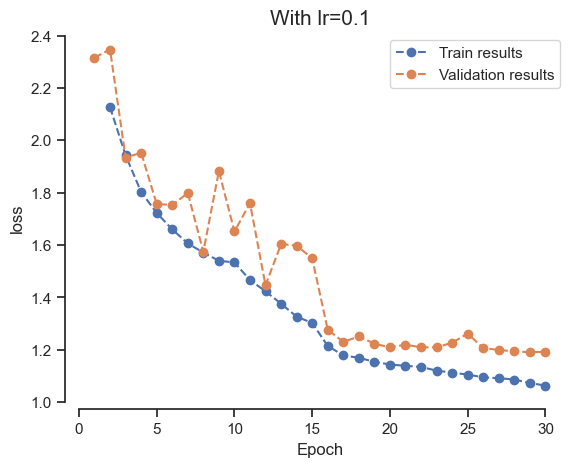

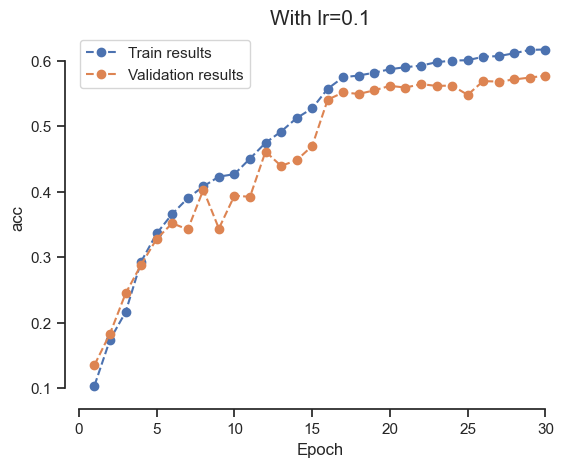

Minimal validation lost: 1.1905343651771545, occured at epoch: 28
Maximal accuracy: 0.5771, occured at epoch: 29


In [12]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

lr = 0.1
model3 = ResNet(in_channels=3, out_channels=10).to(device)
optimizer = optim.Adam(model3.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

res_resnet = utils.run_training(model=model3, optimizer=optimizer, loss_function=loss_fn, device=device, num_epochs=30, train_dataloader=trainloader, val_dataloader=valloader, scheduler=scheduler)
train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = res_resnet
utils.plot(title=f'With lr={lr}', label='loss', train_results=train_losses_resnet, val_results=val_losses_resnet)
utils.plot(title=f'With lr={lr}', label='acc', train_results=train_accs_resnet, val_results=val_accs_resnet)
plt.show()
utils.print_best(val_losses_resnet, val_accs_resnet)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10